# 07. Data Analytics - Linear Regression

In [2]:
import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
from scipy.stats import normaltest
from sklearn import metrics
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from typing import Callable

cmap = sns.diverging_palette(230, 20, as_cmap=True)

/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
# papermill parameters cell
SAVE_FIGS = False
SAVE_MODEL = True
DROP_VARIABLE = True

VARIABLE_TO_PREDICT =  "CCI"
VARIABLE_TO_DROP = []
AREA_TO_PREDICT = "Spain" # "Spain" # "Iberian Pensinula"

RANDOM_STATE = 123456

K_POPULATION = 1
K_GENDER = 1
K_AGE = 1
K_NATIONALITY = 1
K_HOUSING = 1
K_INCOME = 1
K_WEALTH = 1
K_DEBT = 1
K_ECONOMY = 1
K_AGRI = 1
K_TOURISM = 1

In [4]:
AREA_TO_PREDICT_dict = {
    "Andalusia": "01", 
    "Aragon": "02",
    "Asturias": "03", 
    "Balearic Islands": "04",
    "Canarias": "05", 
    "Cantabria": "06",
    "Castile and Leon": "07", 
    "Castille-La Mancha": "08",
    "Catalonia": "09", 
    "Valencia": "10",
    "Extremadura": "11", 
    "Galicia": "12",
    "Madrid": "13", 
    "Murcia": "14",
    "Navarre": "15", 
    "Basque Country": "16",
    "La Rioja": "17",
    "Ceuta": "18",
    "Melilla": "19",
    "Minor Plazas de Soberanía": "20",
    }

## Parameter Check

In [5]:
# Create folders to store the data
DIR_DATA = "data/"
DIR_VAR = DIR_DATA + "processed/{}/{}/".format(VARIABLE_TO_PREDICT, AREA_TO_PREDICT)
DIR_LINEAR = DIR_VAR + "07_linear/"

if SAVE_FIGS is True or SAVE_MODEL is True:
    folder_list = [DIR_VAR, DIR_LINEAR]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [6]:
PATH_TO_FILE = DIR_DATA + "interim/demographic_interimdata/merged_demographic_interimdata/Spatial_demographic_interimdata.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebooks with the same area and "SAVE_DATA" set to True: /n"00acquisition.ipynb", /n"01datamanagement.ipynb", /n"02dataspatialization.ipynb", /n"03index.ipynb"'
    )

## Target Variable

### Dependent variable

In [7]:
# Read CCI results
CCI = pd.read_csv('data/processed/CCI/03_index/CCI_Index.csv')

# Add extra digit to dataset['CTOT'] - if it contains less than 7 characters
CCI['CTOT'] = CCI['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    CCI = CCI[CCI["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    CCI = CCI[~CCI.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    CCI = CCI[~CCI.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    CCI = CCI[~CCI.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    CCI = CCI[~CCI.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    CCI = CCI[~CCI.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

CCI.set_index("CTOT", inplace=True)

### Independent variables

In [8]:
np.random.seed(RANDOM_STATE)

# Read variables dataset into DataFrame
sect = pd.read_csv(DIR_DATA + "interim/demographic_interimdata/merged_demographic_interimdata/Spatial_demographic_interimdata.csv")

# Add extra digit to dataset['CTOT'] - if it contains less than 7 characters
sect['CTOT'] = sect['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    sect = sect[sect["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    sect = sect[~sect.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    sect = sect[~sect.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    sect = sect[~sect.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    sect = sect[~sect.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    sect = sect[~sect.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

sect.set_index("CTOT", inplace=True)

# Drop columns with not needed information
sect.drop(["geometry"], axis=1, inplace=True)

if DROP_VARIABLE is True:
    sect.drop(VARIABLE_TO_DROP, axis=1, inplace=True)

In [9]:
# Read spatial dataset into GeoDataFrame
geo_info = gpd.read_file(DIR_DATA + "interim/AdmBound_interimdata/AdmBound_interimdata.gpkg")

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    geo_info = geo_info[geo_info["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

geo_info.set_index("CTOT", inplace=True)
geo_info = geo_info.drop(["Municipality"], axis=1,)

geo_nans = geo_info.copy()

In [10]:
# Merge datasets to get same shape
geo_info = pd.merge(geo_info, sect, left_index=True, right_index=True)
geo_info = geo_info['geometry']
geo_info = gpd.GeoDataFrame(geo_info)

CCI = pd.merge(CCI, sect, left_index=True, right_index=True)

In [11]:
# Add dependent variable column to spatial dataset
geo_info[VARIABLE_TO_PREDICT] = CCI[VARIABLE_TO_PREDICT]

# Define area with maximum value of dependent variable
print("Area with maximum value: " + str(geo_info[VARIABLE_TO_PREDICT].idxmax()))

Area with maximum value: 0407056


In [12]:
# Dataset information
geo_info.shape
geo_info.dtypes
geo_info.describe()

,CCI
count,8087.000000
mean,0.476041
std,0.152065
min,0.161538
25%,0.340769
50%,0.468091
75%,0.580446
max,0.894161


### Plot target variable

In [13]:
# Define line colors
def line_color(area):
    if area == "Spain" or area == "Iberian Pensinula": color = 'face'
    else: color = "black"
    return color

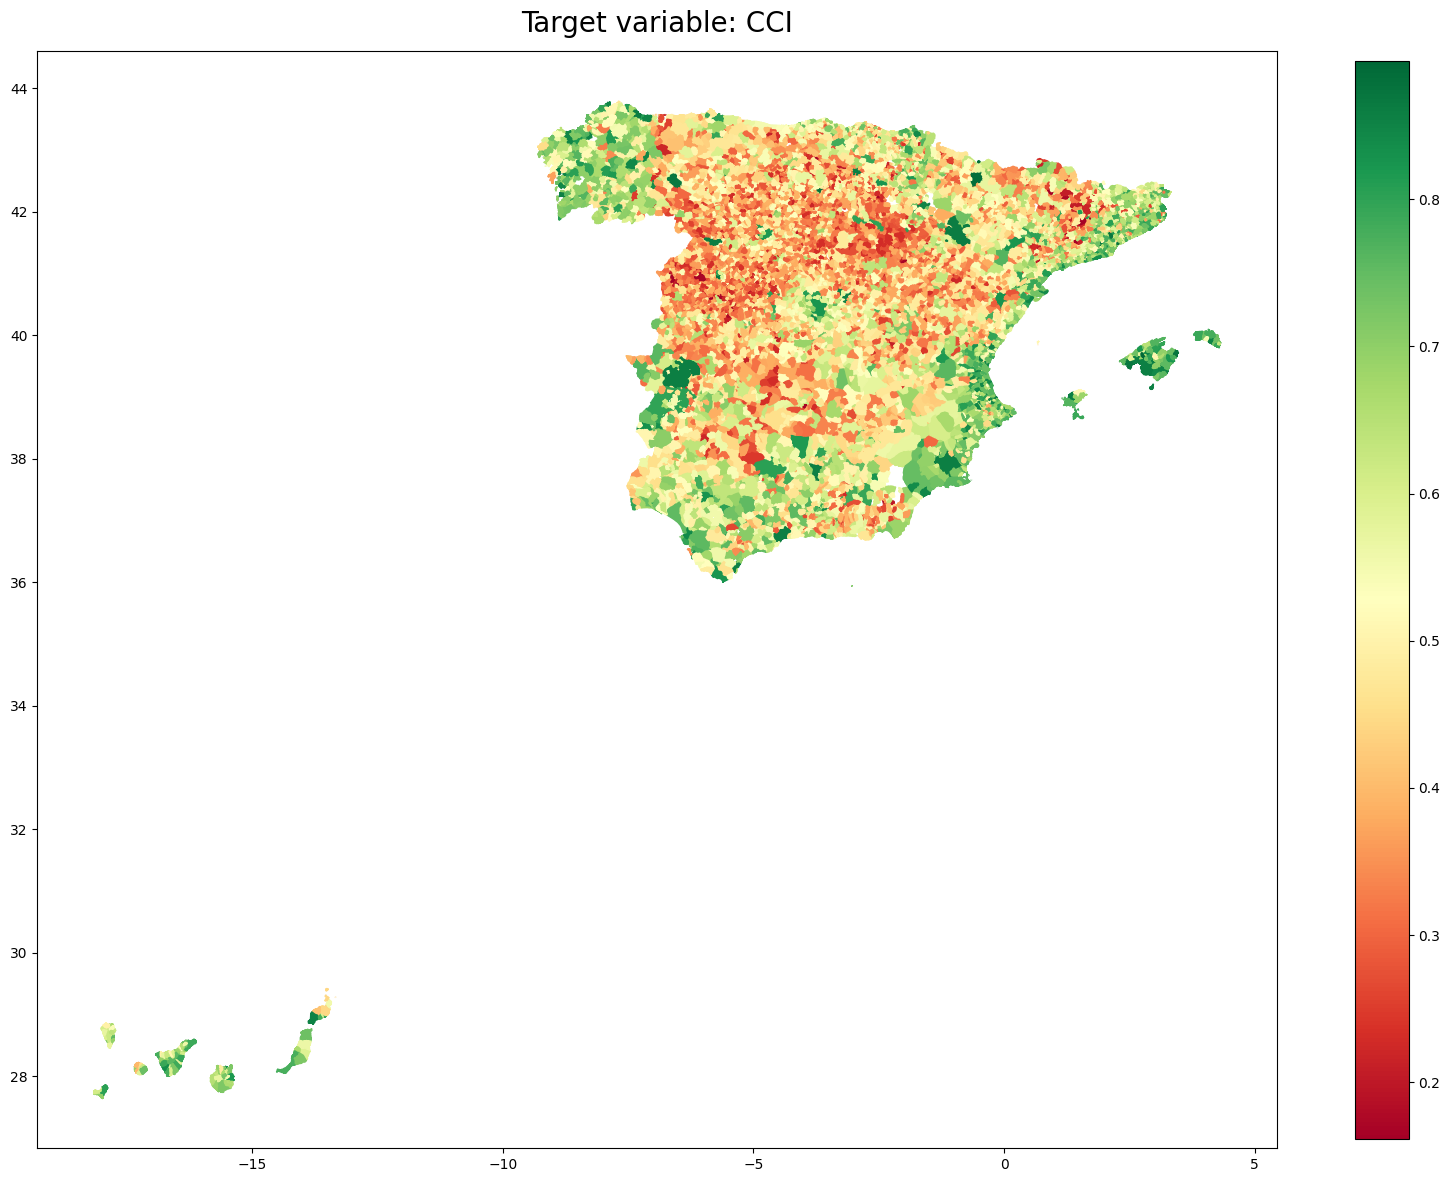

In [14]:
# Plot dependent variable (target variable)
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="RdYlGn",
    legend_kwds={"shrink": 0.7},
)


ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR + "target_variable.svg", format="svg")

plt.show()

In [15]:
# Select data of dependent variable (VARIABLE_TO_PREDICT) and independent variables, drop other columns
if VARIABLE_TO_PREDICT == "CCI":
    y = CCI[VARIABLE_TO_PREDICT]
    X = sect

## NaNs

In [16]:
# Check for missing values of defined features
pd.isnull(X).sum(0)

POPULATION_2020                                                0
POPULATION_DENSITY_KM2_2020                                    0
POPULATION_PERC_NATURAL_GROWTH_2020                            0
GENDER_PERC_POP_FEMALE_2020                                    0
AGE_AVERAGE_2020                                               0
AGE_PERC_POP_BELOW_18_2020                                     0
AGE_PERC_POP_ABOVE_65_2020                                     0
NATIONALITY_PERC_NONSPANISH_2020                               0
HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020                            0
HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020                       0
HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011                     0
INCOME_PER_CAPITA_2020                                      1568
INCOME_PER_HOUSEHOLD_2020                                      8
INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020    1798
WEALTH_GINI_2020                                               0
DEBT_MUNICIPALITY_PER_CAP

In [17]:
# Check for percentage of missing values of defined features
pd.isnull(X).sum(0) / len(X) * 100

POPULATION_2020                                              0.000000
POPULATION_DENSITY_KM2_2020                                  0.000000
POPULATION_PERC_NATURAL_GROWTH_2020                          0.000000
GENDER_PERC_POP_FEMALE_2020                                  0.000000
AGE_AVERAGE_2020                                             0.000000
AGE_PERC_POP_BELOW_18_2020                                   0.000000
AGE_PERC_POP_ABOVE_65_2020                                   0.000000
NATIONALITY_PERC_NONSPANISH_2020                             0.000000
HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020                          0.000000
HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020                     0.000000
HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011                   0.000000
INCOME_PER_CAPITA_2020                                      19.389143
INCOME_PER_HOUSEHOLD_2020                                    0.098924
INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020    22.233214
WEALTH_GINI_2020    

In [18]:
# define the colormap
cmap = plt.cm.YlOrRd # plt.cm.Accent_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (0.5, 0.5, 0.5, 1.0)
cmaplist[0] = "0.8"
# define the bins and normalize
bounds = np.linspace(0, 8, 9)
my_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)

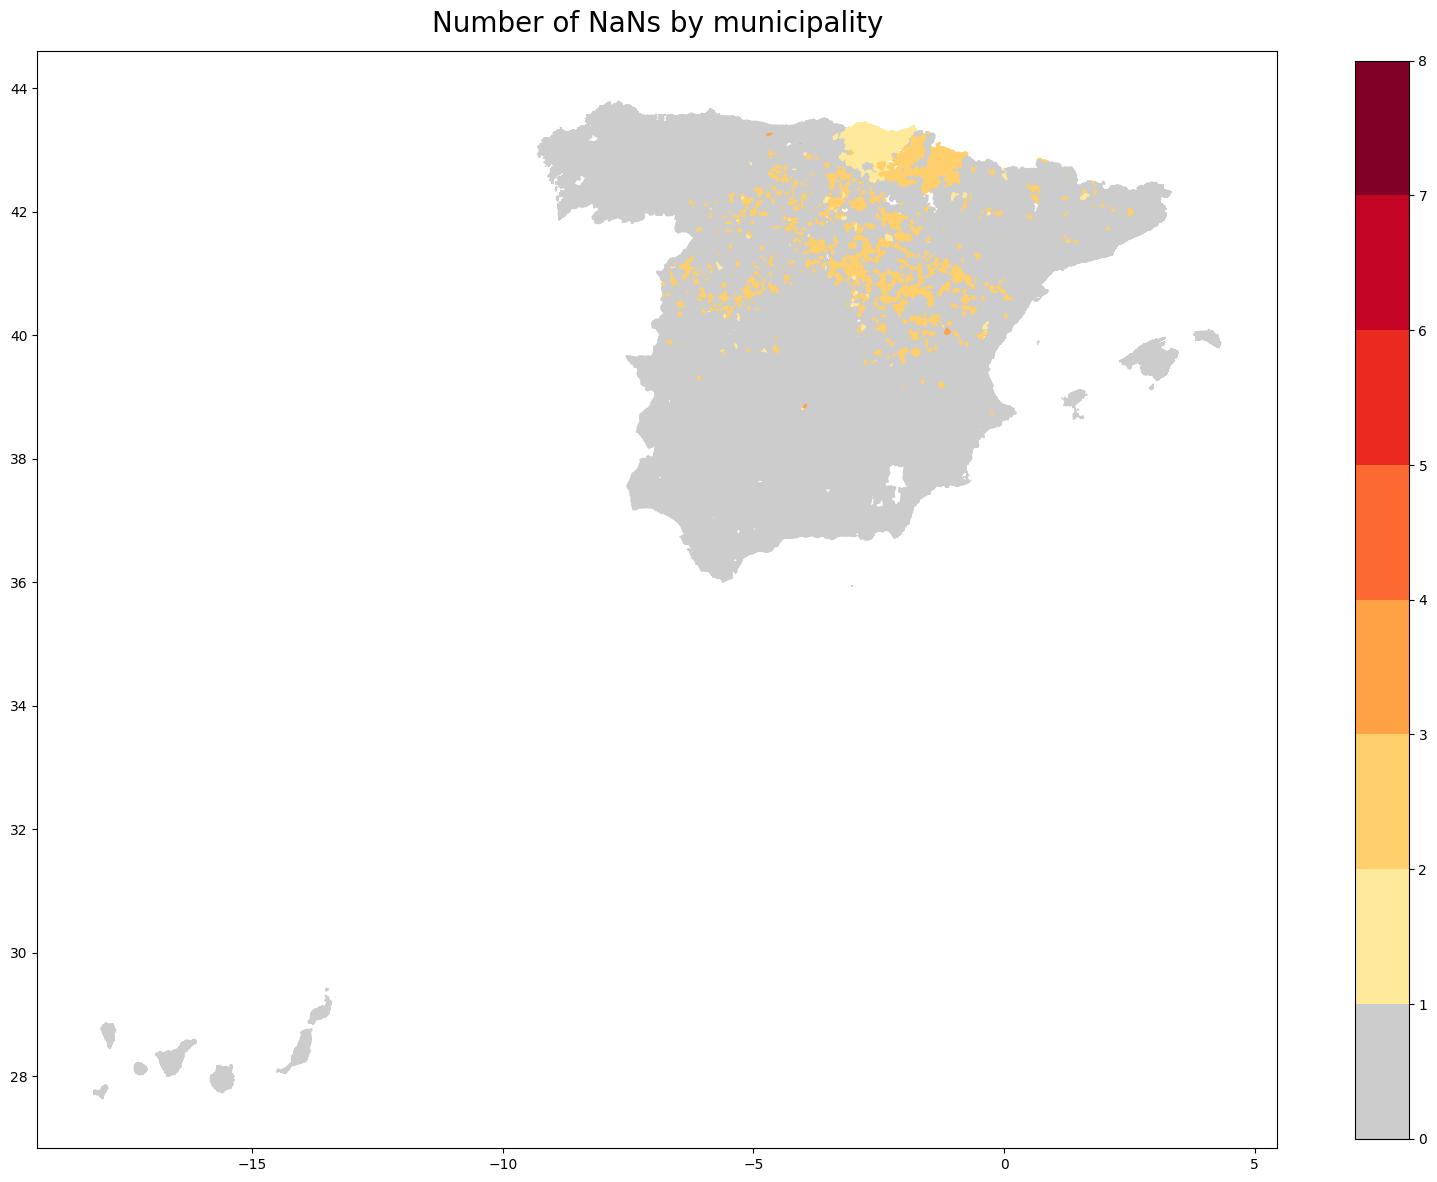

In [19]:
# Plot NaN values
geo_nans["NaNs"] = pd.isnull(sect).sum(axis=1)

fig, ax = plt.subplots(figsize=(20, 20))

geo_nans.plot(
    ax=ax,
    column="NaNs",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    norm=my_norm,
    cmap=my_cmap, 
    figsize=(20, 20),
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Number of NaNs by municipality", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_LINEAR + "nans.svg", format="svg")

plt.show()

## First model: All features

### Pipeline fit

In [20]:
# Apply KNNImputer (for data imputation) and StandardScaler (for data normalization) - connect to pipeline fit
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("scaler", StandardScaler())])

pipe_all = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

### Sensitivity analysis

In [21]:
# Perform sensitivity analysis on data
cv_all = cross_validate(
    pipe_all,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_all = pd.DataFrame(
    [est.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)

medians_all = coefs_all.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
coefs_all = coefs_all[medians_all.index]

limit_value = (
    max(abs(coefs_all.to_numpy().min()), abs(coefs_all.to_numpy().max())) * 1.05
)

In [22]:
coefs_all.mean()

AGE_AVERAGE_2020                                           -0.063224
HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020                   -0.033218
HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020                        -0.032859
INCOME_PER_HOUSEHOLD_2020                                   0.027182
GENDER_PERC_POP_FEMALE_2020                                 0.026198
POPULATION_2020                                             0.025613
AGE_PERC_POP_ABOVE_65_2020                                  0.019418
INCOME_PER_CAPITA_2020                                     -0.016651
ECONOMY_COMPANIES_PER_CAPITA_2020                          -0.014679
NATIONALITY_PERC_NONSPANISH_2020                            0.012045
AGRI_CATTLEFARMS_DENSITY_KM2_2020                           0.014937
WEALTH_GINI_2020                                            0.008754
TOURISM_HOUSES_PER_CAPITA_2022                              0.008537
DEBT_MUNICIPALITY_PER_CAPITA_2021                           0.007156
POPULATION_PERC_NATURAL_GROWTH_202

/root/venv/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


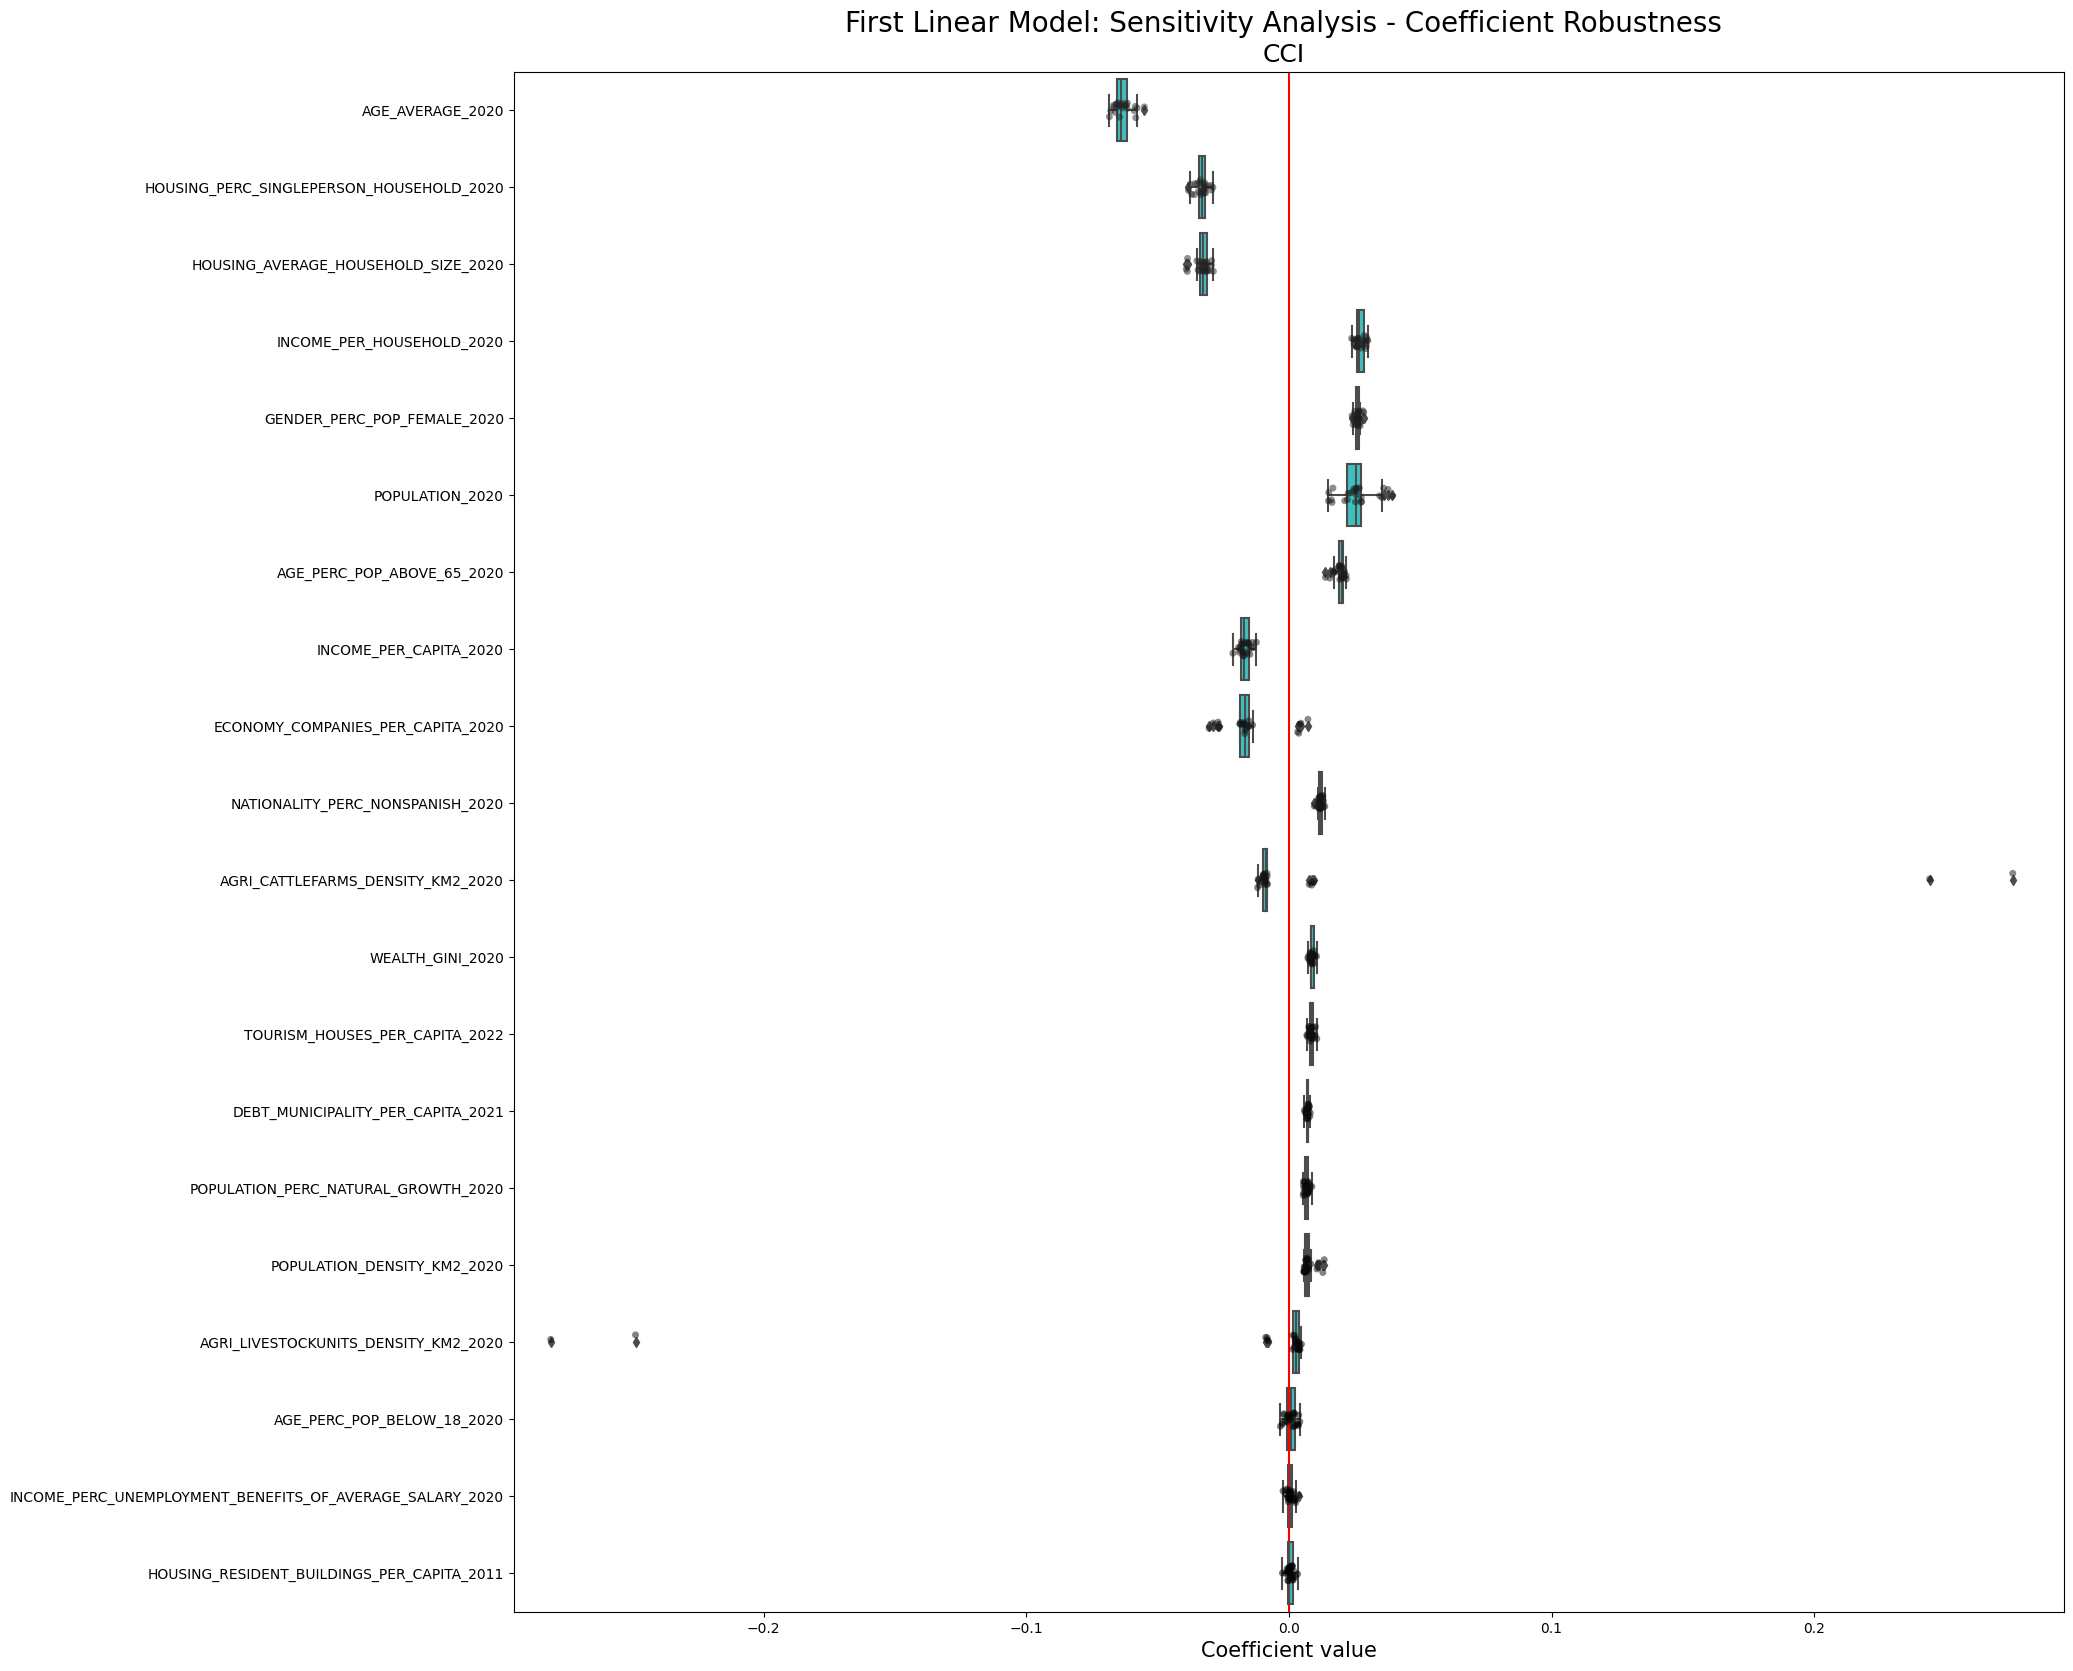

In [23]:
# Plot sensitivity analysis
fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(ax=ax, data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(ax=ax, data=coefs_all, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")

plt.figtext(0.51, 0.9, "First Linear Model: Sensitivity Analysis - Coefficient Robustness", fontsize=20, ha="center")
plt.figtext(
    0.51,
    0.885,
    VARIABLE_TO_PREDICT,
    fontsize=18,
    ha="center",
)
ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR + "sensitivity_first_model.svg", format="svg")

plt.show()

## Second model: Transformations and feature selection

### Normality tests

In [24]:
# Define function for normality tests.
seed(RANDOM_STATE)

# Normality test for large datasets - study area of Spain
def normaltest_dagostino(data, alpha=0.05, verbose=False, n_threshold=20, **kwargs):
    # kurtosistest only valid for n>=20
    if len(data.dropna()) <= n_threshold:
        return np.nan

    # normality test
    stat, p = normaltest(data, **kwargs)

    if verbose is True:
        print("Statistics=%.3f, p=%.3f" % (stat, p))
    # interpret
    if p > alpha:
        if verbose is True:
            print("Sample looks Gaussian (fail to reject H0)")
        return True
    else:
        if verbose is True:
            print("Sample does not look Gaussian (reject H0)")
        return False

def get_normaltest_df(
    df, alpha=0.05, dagostino_n_threshold=20, verbose=False
):
    """Returns df with Normality test per index."""
    results_series = {}
    for measure, data in df.iterrows():
        result_dagostino = normaltest_dagostino(
            data,
            alpha=alpha,
            n_threshold=dagostino_n_threshold,
            nan_policy="omit",
            verbose=verbose,
        )
        results_series.update(
            {measure: {"dagostino": result_dagostino}}
        )
    return pd.DataFrame(results_series).T

In [25]:
# Check which variables are already normal
normality_test = get_normaltest_df(X.T) #(sect.T)

print(normality_test["dagostino"].value_counts())

dagostino
False    20
Name: count, dtype: int64


### Preprocessing Pipeline

In [26]:
# Apply Yeo-Johnson Power Transformer to normalize pipeline fit
pt = PowerTransformer()
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("pt", pt)])

### Feature Selection by Subgroups

In [27]:
# Feature selection
class KBestSelector:
    def __init__(
        self,
        score_func: Callable,
        preprocessor: Pipeline,
        power_transformer: PowerTransformer,
        y: pd.Series,
    ):
        self.score_func = score_func
        self.preprocessor = preprocessor
        self.power_transformer = power_transformer
        self.y = y

    def k_best_selection(self, features: pd.DataFrame, k: int) -> pd.Index:
        kbest_features = SelectKBest(score_func=self.score_func, k=k).fit(
            self.preprocessor.fit_transform(features),
            self.power_transformer.fit_transform(self.y.values.reshape(-1, 1)),
        )

        selected_features_cols = kbest_features.get_support(indices=True)
        return features.columns[selected_features_cols]

In [28]:
# Integrate feature selection into pipeline
selector = KBestSelector(
    score_func=f_regression, preprocessor=preprocessor, power_transformer=pt, y=y
)

In [29]:
# Create subgroups by type of characteristic
X_POPULATION = X.filter(regex="^POPULATION_")
X_POPULATION_chosen = selector.k_best_selection(features=X_POPULATION, k=K_POPULATION)

X_GENDER = X.filter(regex="^GENDER_")
X_GENDER_chosen = selector.k_best_selection(features=X_GENDER, k=K_GENDER)

X_AGE = X.filter(regex="^AGE_")
X_AGE_chosen = selector.k_best_selection(features=X_AGE, k=K_AGE)

X_NATIONALITY = X.filter(regex="^NATIONALITY_")
X_NATIONALITY_chosen = selector.k_best_selection(features=X_NATIONALITY, k=K_NATIONALITY)

X_HOUSING = X.filter(regex="^HOUSING_")
X_HOUSING_chosen = selector.k_best_selection(features=X_HOUSING, k=K_HOUSING)

X_INCOME = X.filter(regex="^INCOME_")
X_INCOME_chosen = selector.k_best_selection(features=X_INCOME, k=K_INCOME)

X_WEALTH = X.filter(regex="^WEALTH_")
X_WEALTH_chosen = selector.k_best_selection(features=X_WEALTH, k=K_WEALTH)

X_DEBT = X.filter(regex="^DEBT_")
X_DEBT_chosen = selector.k_best_selection(features=X_DEBT, k=K_DEBT)

X_ECONOMY = X.filter(regex="^ECONOMY_")
X_ECONOMY_chosen = selector.k_best_selection(features=X_ECONOMY, k=K_ECONOMY)

X_AGRI = X.filter(regex="^AGRI_")
X_AGRI_chosen = selector.k_best_selection(features=X_AGRI, k=K_AGRI)

X_TOURISM = X.filter(regex="^TOURISM_")
X_TOURISM_chosen = selector.k_best_selection(features=X_TOURISM, k=K_TOURISM)


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

In [30]:
# Drop features so that sub-group contains a specified number

X.drop(np.setdiff1d(X_POPULATION.columns, X_POPULATION_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_GENDER.columns, X_GENDER_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_AGE.columns, X_AGE_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_NATIONALITY.columns, X_NATIONALITY_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_HOUSING.columns, X_HOUSING_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_INCOME.columns, X_INCOME_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_WEALTH.columns, X_WEALTH_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_DEBT.columns, X_DEBT_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_ECONOMY.columns, X_ECONOMY_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_AGRI.columns, X_AGRI_chosen), axis=1, inplace=True)
X.drop(np.setdiff1d(X_TOURISM.columns, X_TOURISM_chosen), axis=1, inplace=True)

### Feature Selection Pipeline

In [31]:
# Define type of regressor to implement
myRegressor = LinearRegression()

# Define a pipeline with the preprocessing, feature selection RFE (Recursive Feature Elimination) and regressor
pipe_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rfe", RFE(estimator=myRegressor)),
        ("regressor", myRegressor),
    ]
)

# Define the param space for hyper-parameter tunning (in this case, the number of features to keep with RFE)
#nr_of_features = len(X.axes[1])
param_grid_rfe = [{"rfe__n_features_to_select": np.arange(6, 15, 1)}] #np.arange(nr_of_features, 15, 1)}]

search_rfe = GridSearchCV(
    pipe_rfe, param_grid_rfe, scoring="neg_root_mean_squared_error", n_jobs=-1
)

# The target feature will be transformed with PowerTransformer (TransformedTargetRegressor)
model = TransformedTargetRegressor(regressor=search_rfe, transformer=PowerTransformer())

model.fit(X, y)

TransformedTargetRegressor(regressor=GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                                                             Pipeline(steps=[('imputer',
                                                                                              KNNImputer()),
                                                                                             ('pt',
                                                                                              PowerTransformer())])),
                                                                            ('rfe',
                                                                             RFE(estimator=LinearRegression())),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  n_jobs=-1,
                                                  param_grid=[{'rfe__n_features_to_select': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14])}],
                                                  scoring='neg_root_mean_squared_error'),
                           transformer=PowerTransformer())

In [32]:
# Print outcomes of best model
print("Best Model:")
print(
    "Number of features: "
    + str(model.regressor_.best_params_["rfe__n_features_to_select"])
)
print("\nList of features:")
cols_rfe = model.regressor_.best_estimator_.named_steps["rfe"].get_support(indices=True)
print(X.columns[cols_rfe])

Best Model:
Number of features: 11

List of features:
Index(['POPULATION_2020', 'GENDER_PERC_POP_FEMALE_2020', 'AGE_AVERAGE_2020',
       'NATIONALITY_PERC_NONSPANISH_2020',
       'HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011',
       'INCOME_PER_HOUSEHOLD_2020', 'WEALTH_GINI_2020',
       'DEBT_MUNICIPALITY_PER_CAPITA_2021',
       'ECONOMY_COMPANIES_PER_CAPITA_2020',
       'AGRI_CATTLEFARMS_DENSITY_KM2_2020', 'TOURISM_HOUSES_PER_CAPITA_2022'],
      dtype='object')


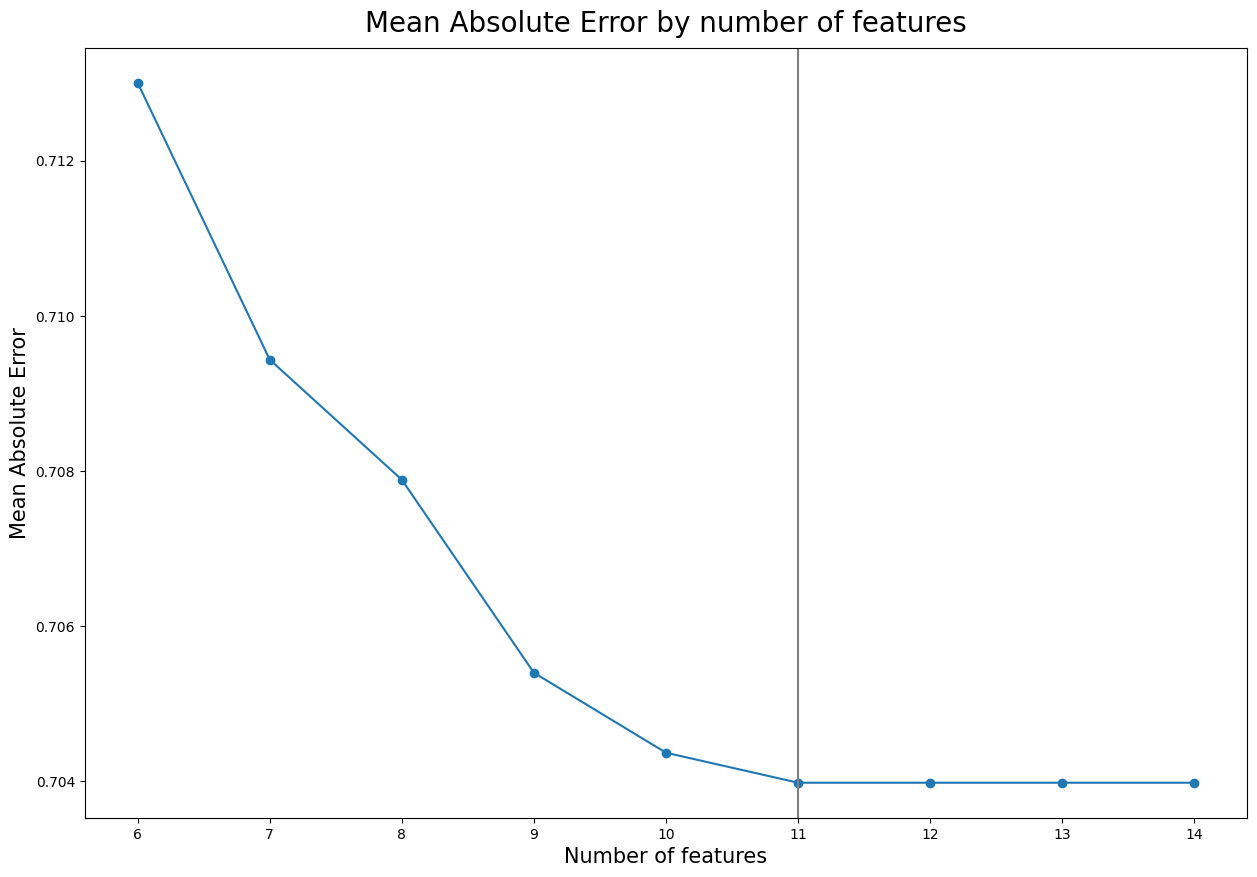

In [33]:
# Plot the score by number of features - best model
score_features = -model.regressor_.cv_results_["mean_test_score"]
n_features = []
for i in model.regressor_.cv_results_["params"]:
    n_features.append(i["rfe__n_features_to_select"])

id_min_score = score_features.argmin()

fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(n_features, score_features, marker="o")
plt.axvline(x=n_features[id_min_score], color=".5")

ax.set_xlabel("Number of features", fontsize=15)
ax.set_ylabel("Mean Absolute Error", fontsize=15)
ax.set_xticks(np.arange(min(n_features), max(n_features) + 1))
ax.set_title("Mean Absolute Error by number of features", fontsize=20, y=1.01)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR + "rmse.svg", format="svg")

plt.show()

## Model predictions

In [34]:
# Create class to calculate accuracy of model predictions
class PredictedAccuracy:
    def __init__(self, y_series, yhat_series):
        if isinstance(yhat_series, np.ndarray):
            yhat_series = pd.Series(yhat_series, name=f"predicted {y_series.name}")
            yhat_series.index = y_series.index

        self.y_series = y_series
        self.yhat_series = yhat_series
        self.eps = self.y_series - self.yhat_series

    def regression_accuracy_metrics(y, yhat):
        mse = metrics.mean_squared_error(y, yhat)

        metrics_dict = {
            "MAE": metrics.mean_absolute_error(y, yhat),
            "MSE": mse,
            "RMSE": np.sqrt(mse),
            "r2": metrics.r2_score(y, yhat),
        }

        return metrics_dict

    def metrics(self):
        return PredictedAccuracy.regression_accuracy_metrics(
            self.y_series, self.yhat_series
        )

    def pretty_metrics(self, decimals: int = 2, separation_string: str = ", "):
        return separation_string.join(
            [
                f"{k}: {round(v, decimals):.{decimals}f}"
                for k, v in self.metrics().items()
            ]
        )

    def plot_scatter(self, save_fig=False, root_name="generic_figure"):
        plt.close()
        plt.figure(figsize=(15, 15))
        y_max0 = self.y_series.max()
        y_min0 = self.y_series.min()
        x_max0 = self.yhat_series.max()
        x_min0 = self.yhat_series.min()
        x_max_min0 = x_max0 - x_min0
        y_max_min0 = y_max0 - y_min0
        x_padding0 = 0.1 * x_max_min0
        y_padding0 = 0.1 * y_max_min0

        axis_min0 = min(x_min0 - x_padding0, y_min0 - y_padding0)
        axis_max0 = max(x_max0 + x_padding0, y_max0 + y_padding0)
        plt.axis("square")
        plt.rcParams["axes.grid"] = False

        plt.xlim([axis_min0, axis_max0])
        plt.ylim([axis_min0, axis_max0])
        plt.xlabel("Predicted value")
        plt.ylabel("Real value")
        plt.title(
            str(self.y_series.name) + "\n" + str(self.pretty_metrics()), fontsize=15
        )
        plt.scatter(self.yhat_series, self.y_series)
        plt.plot([axis_min0, axis_max0], [axis_min0, axis_max0], color="c")

        if save_fig is True:
            plt.savefig(str(root_name) + "0.svg", format="svg")

        plt.show()

    def plot_errors(self, save_fig=False, root_name="generic_figure"):
        plt.close()
        plt.figure(figsize=(15, 15))
        x_max1 = self.yhat_series.max()
        x_min1 = self.yhat_series.min()
        y_max1 = self.eps.max()
        y_min1 = self.eps.min()
        x_max_min1 = x_max1 - x_min1
        y_max_min1 = y_max1 - y_min1
        x_padding1 = 0.1 * x_max_min1
        y_padding1 = 0.1 * y_max_min1

        axis_min1 = min(x_min1 - x_padding1, y_min1 - y_padding1)
        axis_max1 = max(x_max1 + x_padding1, y_max1 + y_padding1)

        plt.rcParams["axes.grid"] = False

        plt.scatter(self.yhat_series, self.eps)
        plt.plot([axis_min1, axis_max1], [0, 0], "c--")

        plt.xlim([x_min1 - x_padding1, x_max1 + x_padding1])
        plt.ylim([-axis_max1, axis_max1])
        plt.xlabel("Predicted value")
        plt.ylabel("Error")
        plt.title(self.y_series.name, fontsize=15)

        if save_fig is True:
            plt.savefig(str(root_name) + "1.svg", format="svg")

        plt.show()

### First Model (with feature selection)

In [35]:
# Define predicted accuracy for model
y_pred_rfe = model.predict(X).round()
pa_rfe = PredictedAccuracy(y, y_pred_rfe)

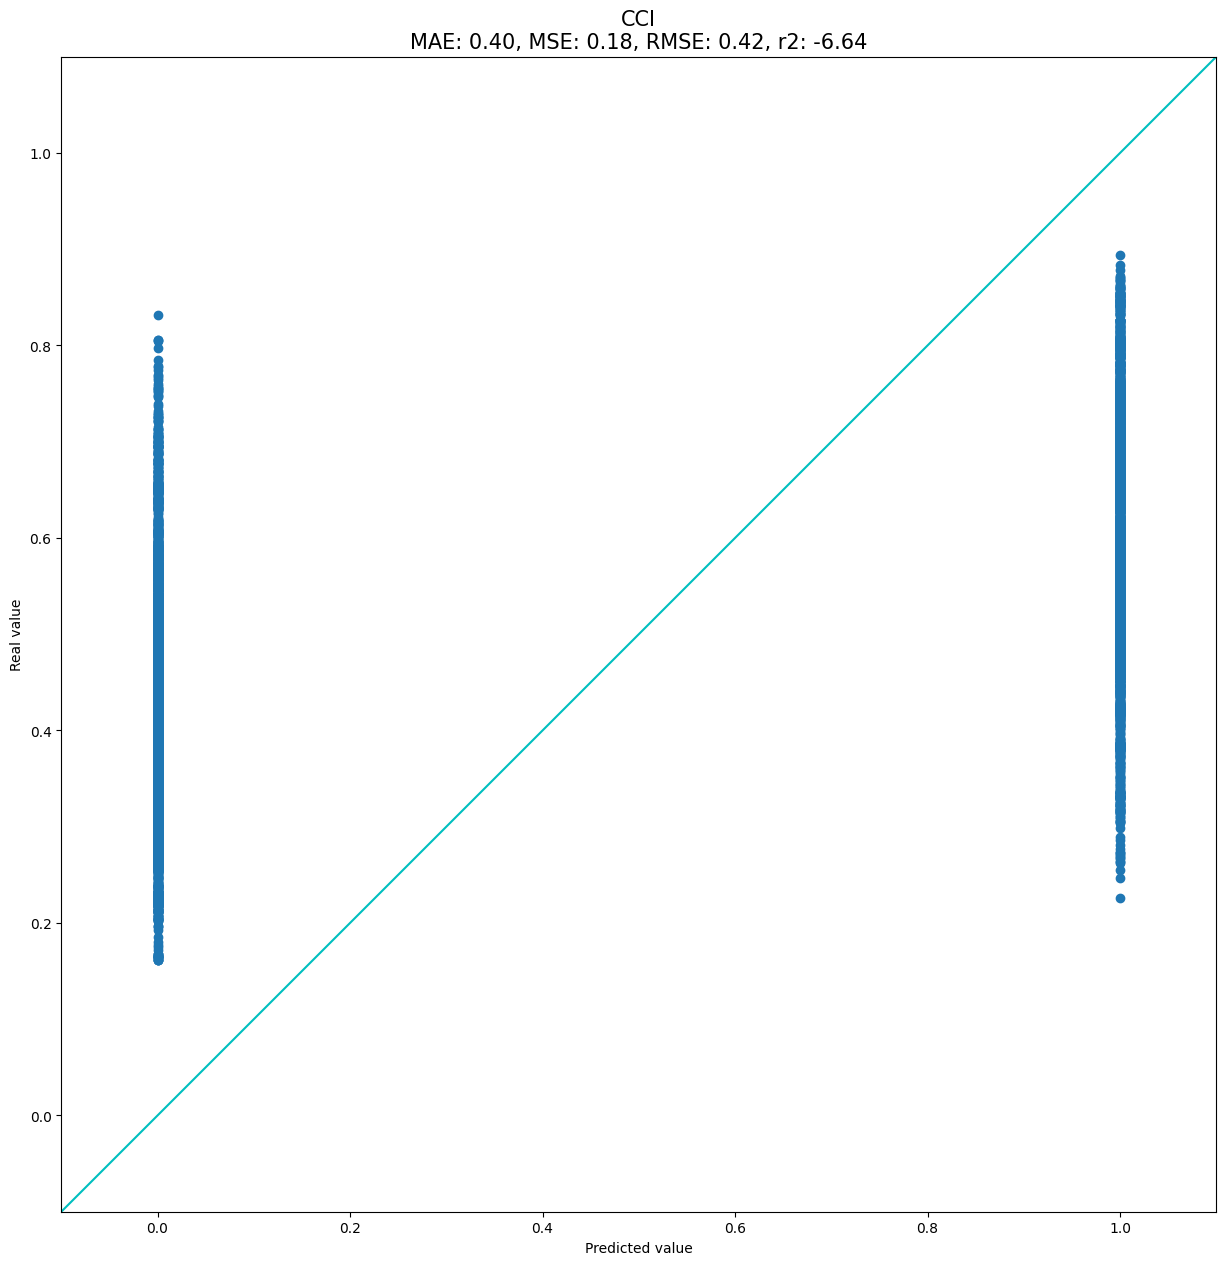

In [36]:
# Plot predicted accuracy for linear regression (scatter plot)
pa_rfe.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_LINEAR + "model")

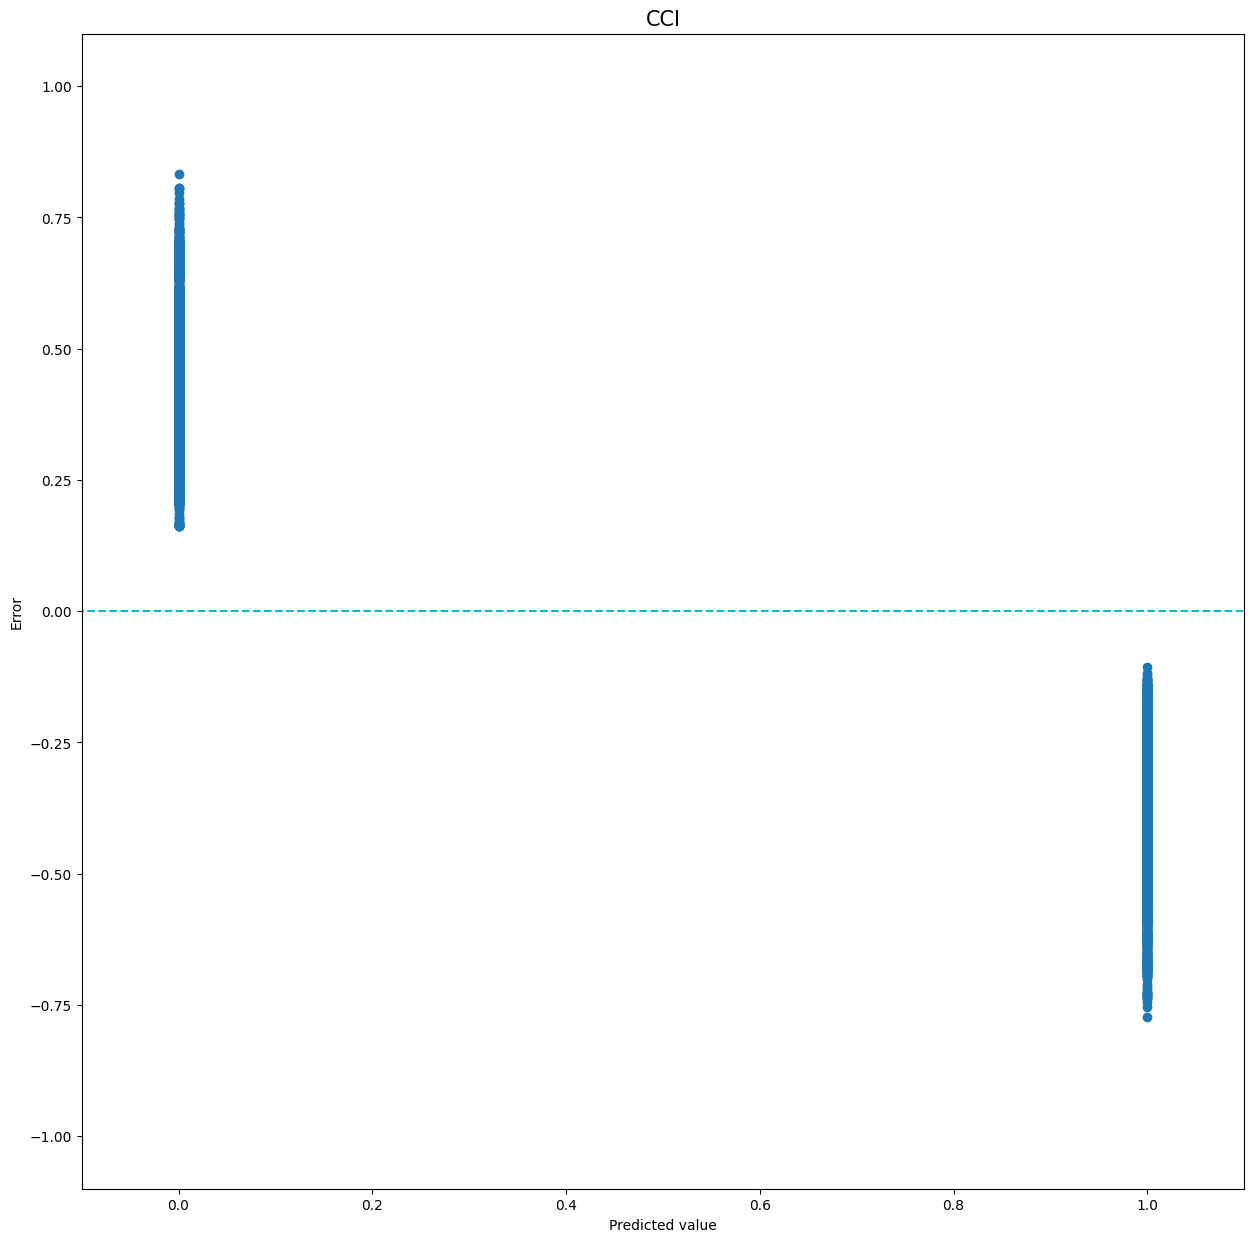

In [37]:
# Plot predicted accuracy for linear regression (errors)
pa_rfe.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_LINEAR + "model")

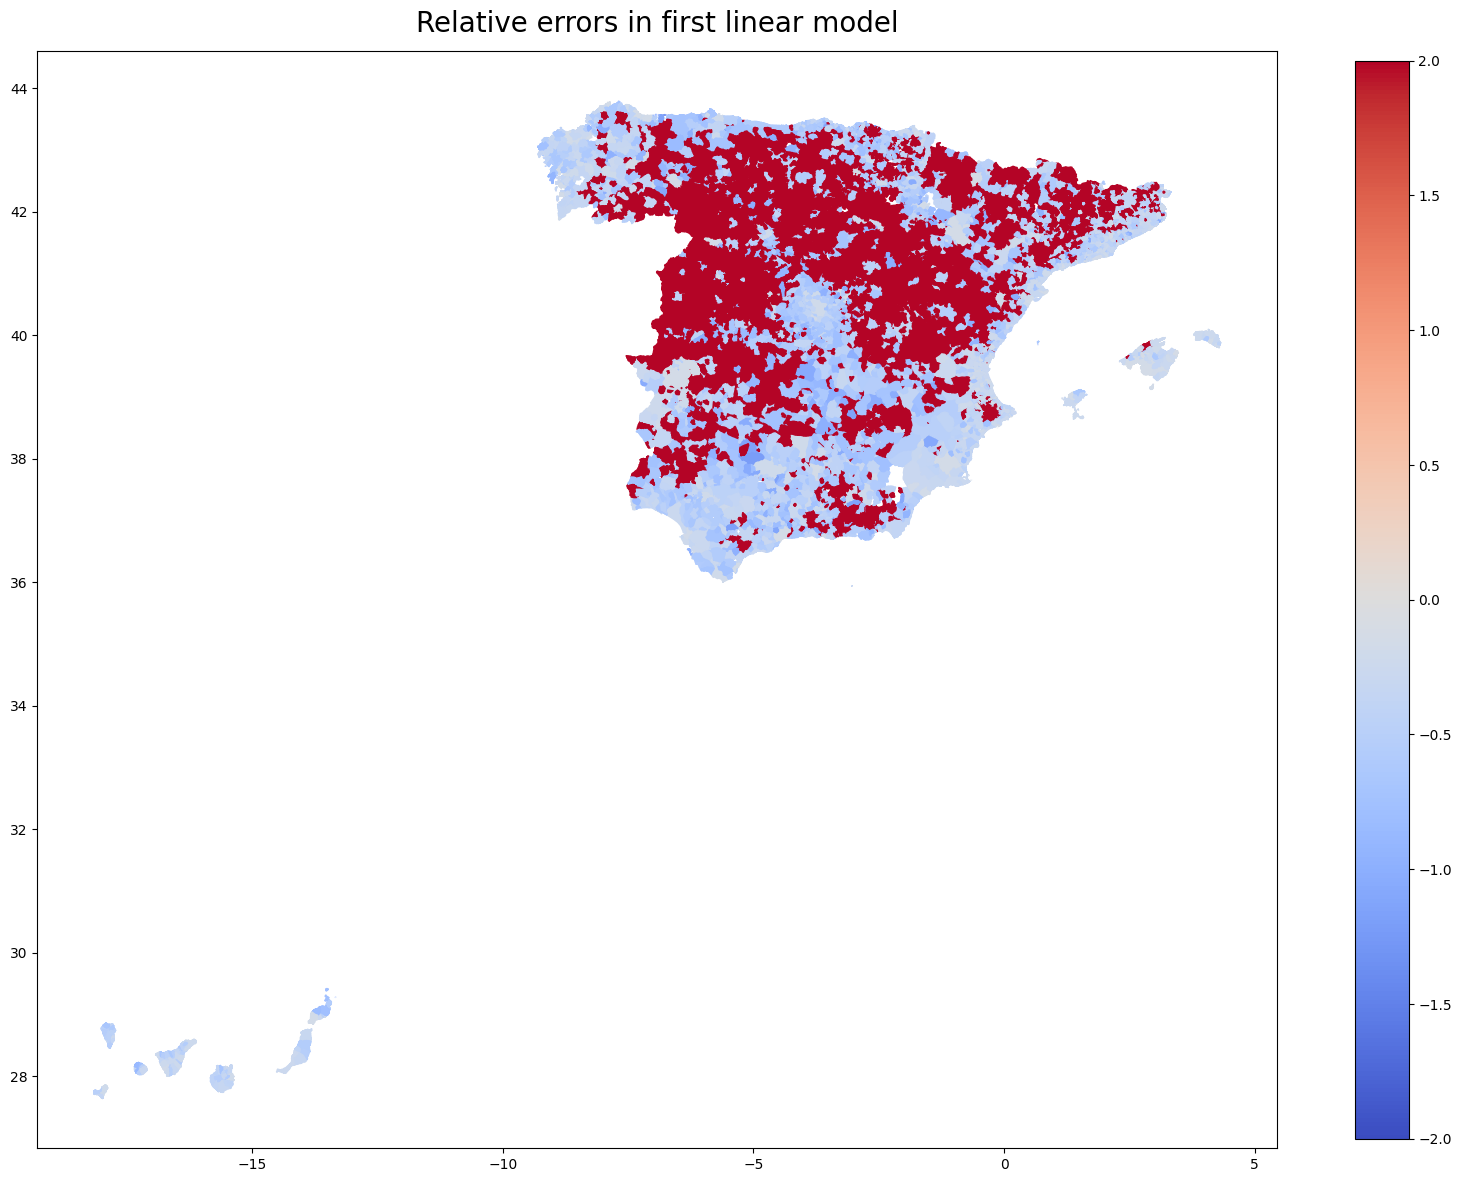

In [38]:
# Plot relative errors in linear model on map
geo_info["Chosen_Error"] = 2 * (y - y_pred_rfe) / (abs(y) + abs(y_pred_rfe))

col_lim = max(abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max()))

fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column="Chosen_Error",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="coolwarm",
    vmin=-col_lim,
    vmax=col_lim,
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Relative errors in first linear model", fontsize=20, y=1.01)


if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR + "relative_errors.svg", format="svg")

plt.show()

In [39]:
if SAVE_MODEL is True:
    geo_info[["Chosen_Error"]].to_csv(DIR_LINEAR + "relative_errors.csv")
    pd.DataFrame(y_pred_rfe, index=geo_info.index, columns=["Predictions"]).to_csv(
        DIR_LINEAR + "predictions.csv"
    )

### Second Model

In [40]:
pw = PowerTransformer()
pw.fit(y.values.reshape(-1, 1))

# Transform y_hat
y_pred_transformed = model.predict(X)
y_pred_transformed = pw.transform(y_pred_transformed.reshape(-1, 1)).flatten()

# Transform y
y_transformed = pd.Series(pw.transform(y.values.reshape(-1, 1)).flatten())
y_transformed.name = "Transformed " + str(VARIABLE_TO_PREDICT)

pa_rfe = PredictedAccuracy(y_transformed, y_pred_transformed)

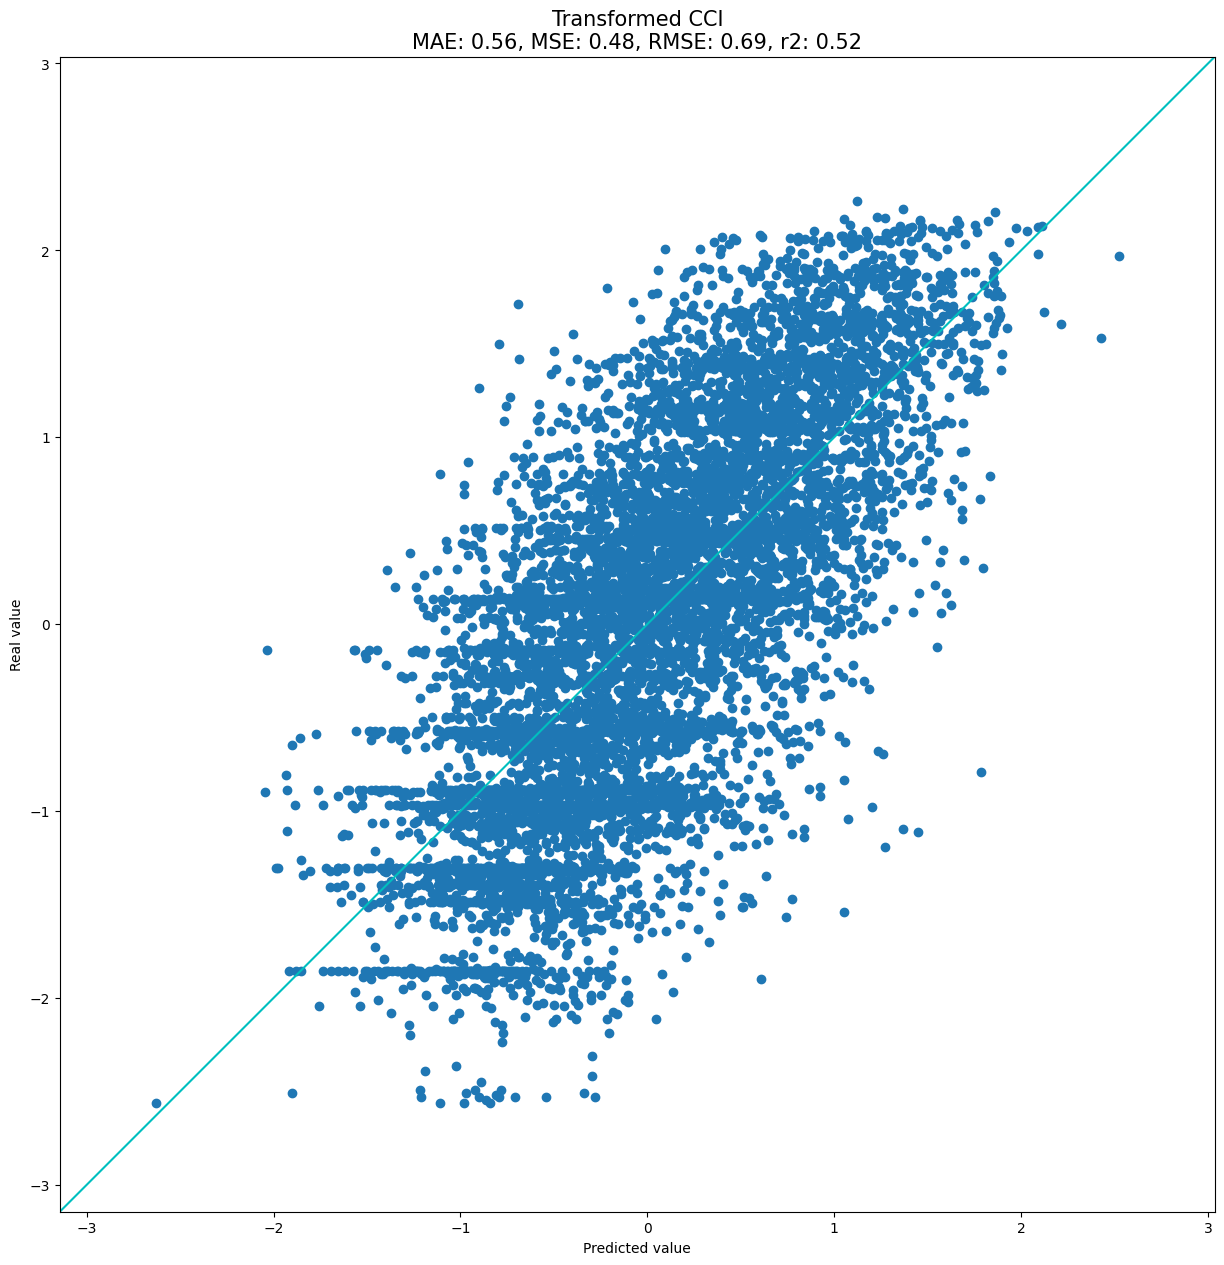

In [41]:
# Plot predicted accuracy for transformed linear regression (scatter plot)
pa_rfe.plot_scatter(save_fig=SAVE_FIGS, root_name=DIR_LINEAR + "transformed_model",)

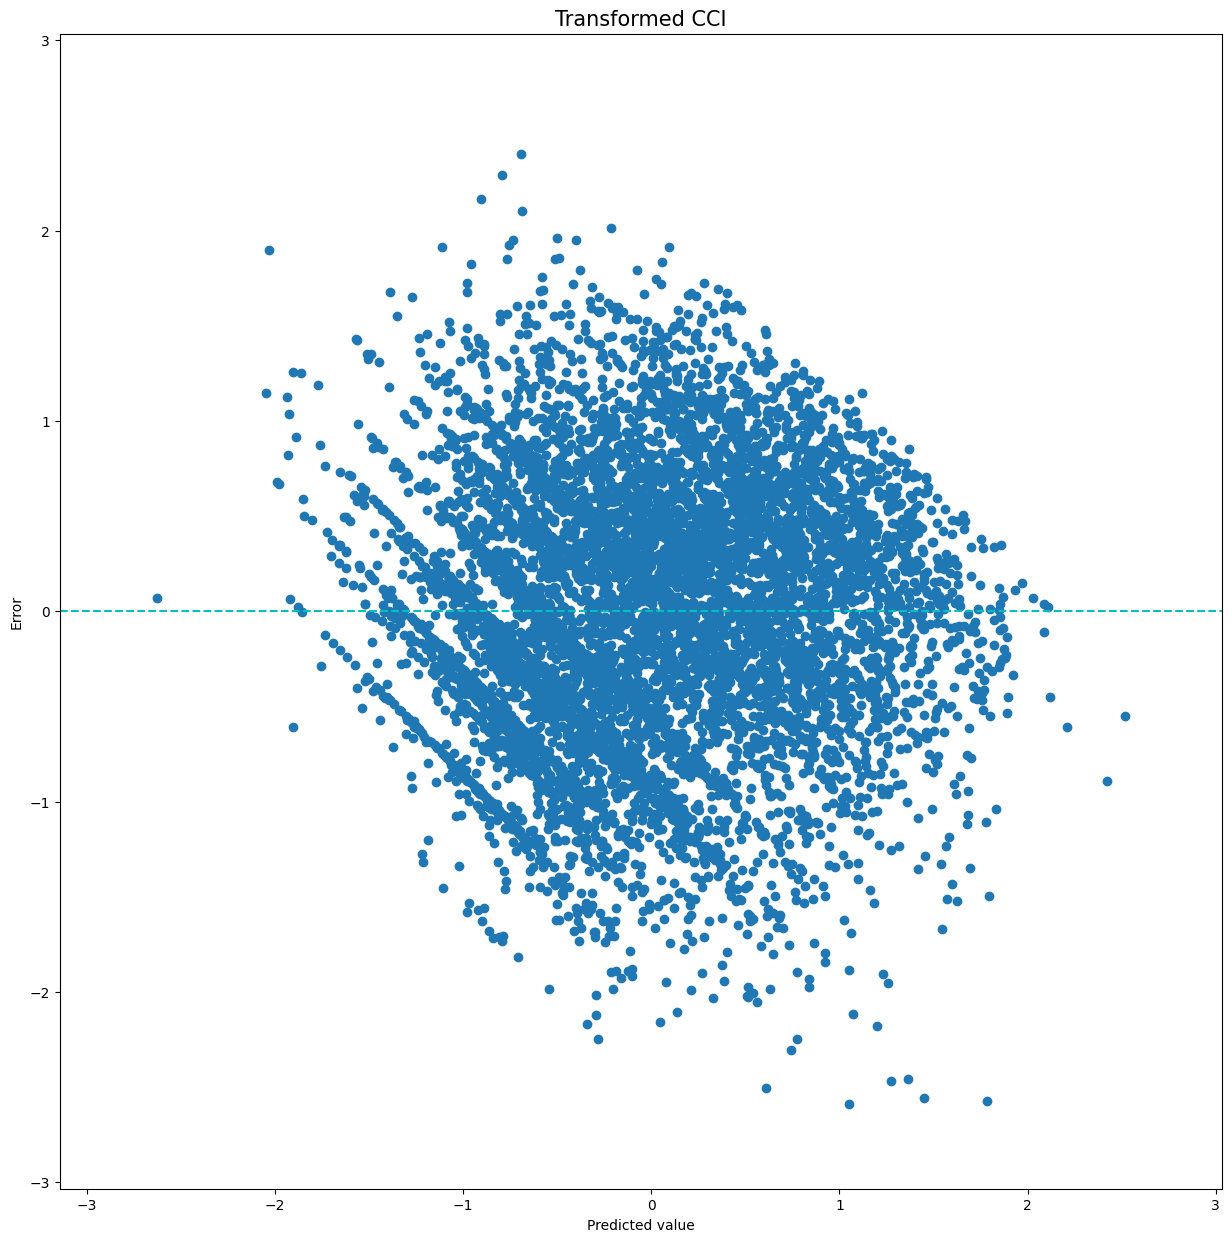

In [42]:
# Plot predicted accuracy for transformed linear regression (errors)
pa_rfe.plot_errors(save_fig=SAVE_FIGS, root_name=DIR_LINEAR + "transformed_model",)

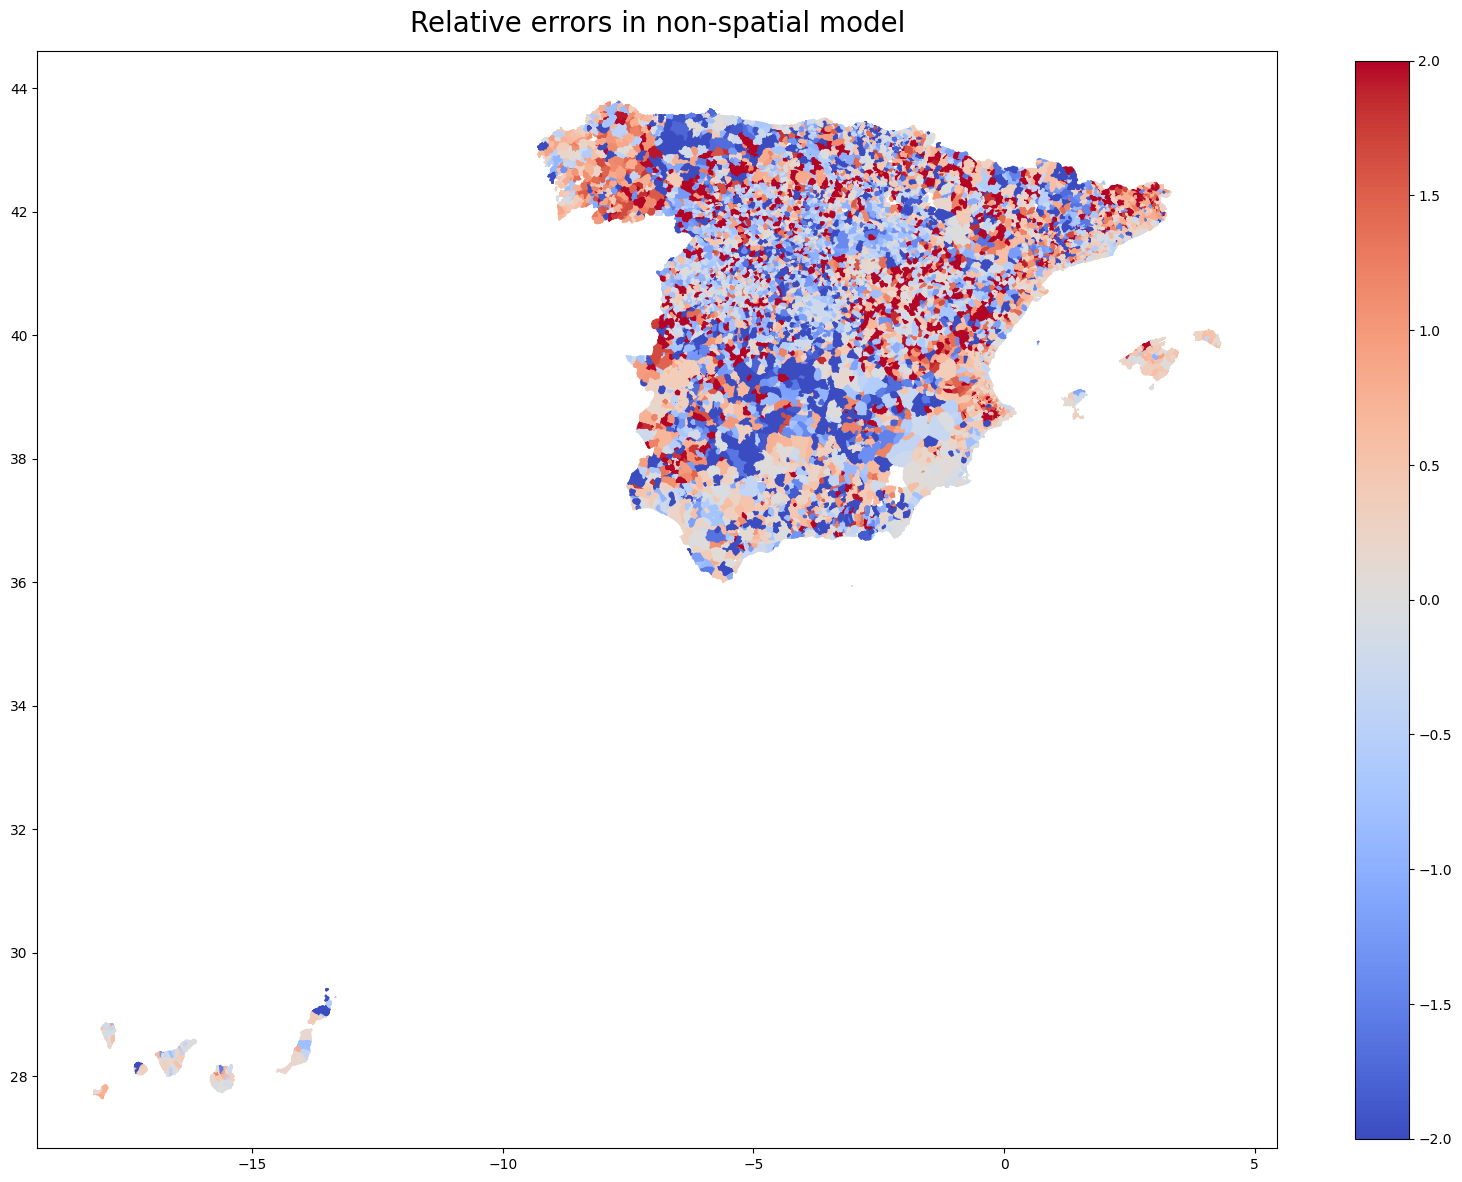

In [43]:
# Plot relative errors in linear model on map
y_transformed.index = y.index
geo_info["Chosen_Error_Transformed"] = 2 * (y_transformed - y_pred_transformed) / (abs(y_transformed) + abs(y_pred_transformed))

col_lim = max(abs(geo_info["Chosen_Error_Transformed"].min()), abs(geo_info["Chosen_Error_Transformed"].max()))

fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column="Chosen_Error_Transformed",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="coolwarm",
    vmin=-col_lim,
    vmax=col_lim,
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Relative errors in non-spatial model", fontsize=20, y=1.01)


if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR + "relative_errors_transformed.svg", format="svg")

plt.show()

### Sensitivity Analysis 

In [44]:
# Define pipeline for sensitivity analysis on relative errors of transformed linear regression
X_rfe = X.iloc[:, cols_rfe]

pipe_sens = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", myRegressor)])

model_sens = TransformedTargetRegressor(
    regressor=pipe_sens, transformer=PowerTransformer()
)

model_sens.fit(X_rfe, y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('imputer',
                                                                       KNNImputer()),
                                                                      ('pt',
                                                                       PowerTransformer())])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=PowerTransformer())

In [45]:
# Perform sensitivity analysis on relative errors of transformed linear regression
cv_rfe = cross_validate(
    model_sens,
    X_rfe,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_rfe = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_rfe["estimator"]],
    columns=X_rfe.columns,
)

coefs_rfe["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_rfe["estimator"]]
)

medians_rfe = coefs_rfe.drop(["Intercept"], axis=1).median()
medians_rfe = medians_rfe.reindex(medians_rfe.abs().sort_values(ascending=False).index)
medians_rfe = medians_rfe.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
coefs_rfe = coefs_rfe[medians_rfe.index]

limit_value = (
    max(abs(coefs_rfe.to_numpy().min()), abs(coefs_rfe.to_numpy().max())) * 1.05
)

AttributeError: 'Series' object has no attribute 'append'

In [ ]:
# Plot sensitivity analysis
fig, ax = plt.subplots(figsize=(20, 20))

sns.stripplot(ax=ax, data=coefs_rfe, orient="h", color="k", alpha=0.5)
sns.boxplot(ax=ax, data=coefs_rfe, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")

plt.figtext(0.51, 0.9, "Second Linear Model: Sensitivity Analysis - Coefficient Robustness", fontsize=20, ha="center")
plt.figtext(
    0.51,
    0.885,
    VARIABLE_TO_PREDICT,
    fontsize=18,
    ha="center",
)
ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient value", fontsize=15)

if SAVE_FIGS is True:
    plt.savefig(DIR_LINEAR + "sensitivity_second_model.svg", format="svg")

plt.show()

In [ ]:
if SAVE_MODEL is True:
    coefs_rfe.to_csv(DIR_LINEAR + "coefficients.csv")
    coefs_rfe.to_csv(
        DIR_VAR + "07_linear/coefficients_{}.csv".format(VARIABLE_TO_PREDICT)
    )

### Comparative Analysis

In [ ]:
# Plot Comparative Analysis of Predicted Accuracy
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Make the axes accessible with single indexing
axs = axs.flatten()

## AXIS 0 ##
# select the axis where the map will go
ax = axs[0]

# Calculate relative error of second model
geo_info["Chosen_Error"] = 2 * (y - y_pred_rfe) / (abs(y) + abs(y_pred_rfe))
col_lim = max(abs(geo_info["Chosen_Error"].min()), abs(geo_info["Chosen_Error"].max()))

# Plot relative errors in second model on map
geo_info.plot(
    ax=ax,
    column="Chosen_Error",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="coolwarm",
    vmin=-col_lim,
    vmax=col_lim,
    legend_kwds={"shrink":10},
)

# Set the axis title to the name of variable being plotted
ax.set_title("Relative errors in second model", fontsize=20, y=1.01)

## AXIS 1 ##
# select the axis where the map will go
ax = axs[1]

# Calculate relative error of transformed second model
y_transformed.index = y.index
geo_info["Chosen_Error_Transformed"] = 2 * (y_transformed - y_pred_transformed) / (abs(y_transformed) + abs(y_pred_transformed))
col_lim = max(abs(geo_info["Chosen_Error_Transformed"].min()), abs(geo_info["Chosen_Error_Transformed"].max()))

# Plot relative errors in transformed second model on map
geo_info.plot(
    ax=ax,
    column="Chosen_Error_Transformed",
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="coolwarm",
    vmin=-col_lim,
    vmax=col_lim,
    legend_kwds={"shrink":10},
)

ax.set_title("Relative errors in transformed second model", fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_LINEAR + "ComparativeAnalysis_Map_Residuals.svg", format="svg")

# Display the figure
plt.show()

## Watermark

In [ ]:
%load_ext watermark

In [ ]:
# NBVAL_IGNORE_OUTPUT
%watermark -a "Rens Wiebe van Wijk" -u -d -t -v -m -g -wb

In [ ]:
# NBVAL_IGNORE_OUTPUT
%watermark -iv

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f11c3f49-2b5e-4e69-9186-d202c2d21fb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>